true: 7, pred: 7


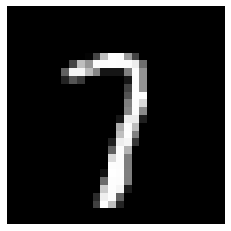

true: 2, pred: 2


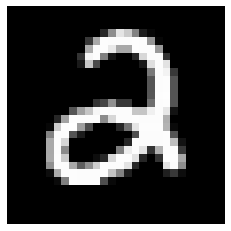

true: 0, pred: 0


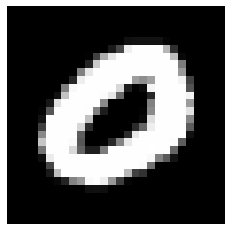

true: 8, pred: 8


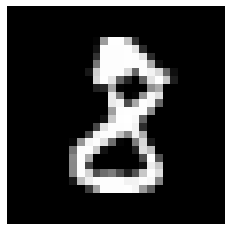

true: 5, pred: 5


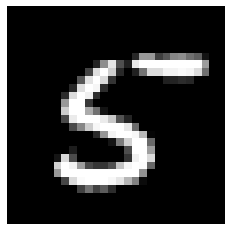

true: 2, pred: 2


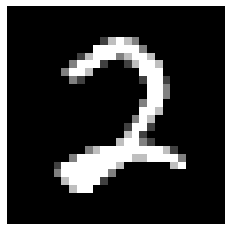

true: 5, pred: 5


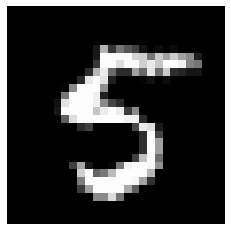

true: 2, pred: 2


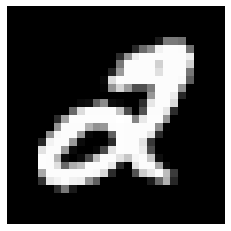

true: 3, pred: 3


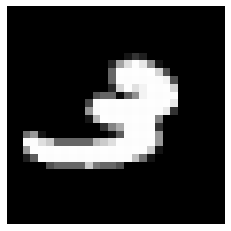

true: 0, pred: 0


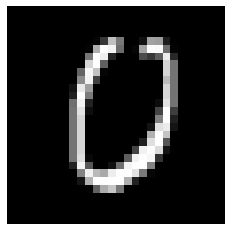

In [52]:
from torchvision import datasets, transforms
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from src import util

model = torch.load('models/cnn_mnist.pt', map_location=torch.device('cpu'))
model.eval()

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset = datasets.MNIST('data', train=False, transform=transform, download=True)
dataset_subset = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), 10, replace=False))
test_loader = torch.utils.data.DataLoader(dataset_subset, batch_size=1, shuffle=False)

single_instance = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), 2, replace=False))
single_loader = torch.utils.data.DataLoader(single_instance, batch_size=1, shuffle=False)

for image, label in test_loader:
    pred = model(image).argmax(axis=1)
    npimg = np.squeeze(np.squeeze(image.numpy()))
    plt.imshow(npimg, cmap='gray')
    print(f'true: {label[0]}, pred: {pred[0]}')
    plt.axis('off')
    plt.show()

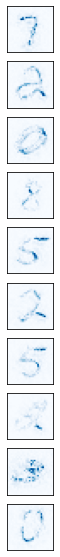

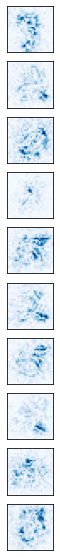

In [112]:
# visualize integrated gradients for mnist cnn

import torchvision
from captum.attr import IntegratedGradients, Saliency, InputXGradient, GuidedBackprop, DeepLift
from captum.attr import visualization as viz

def attribute_image_features(model, algorithm, input, label, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input, target=label, **kwargs)
    
    return tensor_attributions


# Given a NN model, ...
def visualize_saliency_method(saliency_kwargs, image, plt_fig_axis):
    image.requires_grad = True
    attrs = attribute_image_features(**saliency_kwargs)
    attrs = np.transpose(attrs.squeeze(0).cpu().detach().numpy(), (1,2,0))
    original_image = np.transpose(image.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    return viz.visualize_image_attr(attrs, original_image, method="heat_map",sign="absolute_value",
                          plt_fig_axis=plt_fig_axis, cmap="Blues", show_colorbar=False,
                          use_pyplot=False)


ig = IntegratedGradients
fig, axs = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(10, 10))
for (image, label), row in zip(test_loader, range(len(test_loader))):
    ig_kwargs = {
        'model': model,
        'algorithm': ig(model),
        'input': image,
        'label': label,
        'baselines': image * 0} # stuff specific to integrated gradients
    fig, _ = visualize_saliency_method(ig_kwargs, image, (fig, axs[row]))
plt.show(fig)

sal = Saliency
fig, axs = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(10, 10))
for (image, label), row in zip(test_loader, range(len(test_loader))):
    sal_kwargs = {
        'model': model,
        'algorithm': sal(model),
        'input': image,
        'label': label,
    } # stuff specific to gradients (saliency)
    fig, _ = visualize_saliency_method(sal_kwargs, image, (fig, axs[row]))
plt.show(fig)

In [119]:
def get_kwargs(saliency_method, model, image, label):
    sal_kwargs = {
        'algorithm': saliency_method(model),
        'model': model,
        'input': image,
        'label': label,
    }
    
    if saliency_method == IntegratedGradients:
        pass
    elif saliency_method == Saliency:
        pass
    elif saliency_method == InputXGradient:
        pass
    elif saliency_method == GuidedBackprop:
        pass
    elif saliency_method == DeepLift:
        pass
    else:
        raise Exception("Saliency method not supported :(")
    
    return sal_kwargs

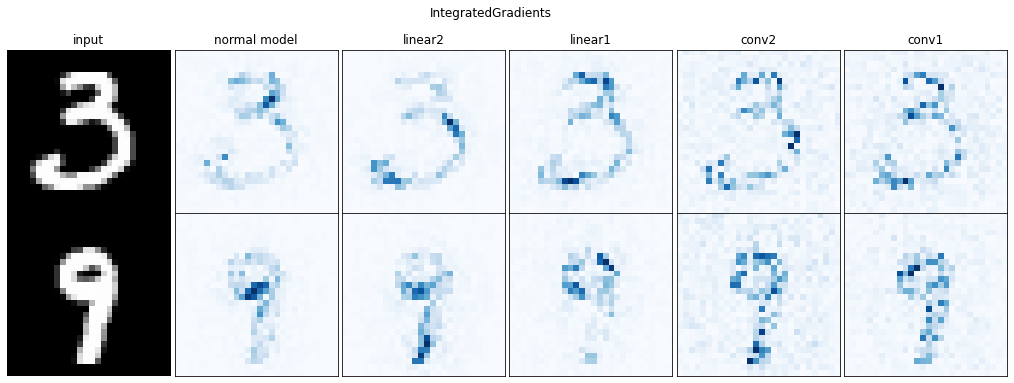

In [114]:
def visualize_cascading_randomization(model, module_paths, examples, saliency_method):
    model_copy = copy.deepcopy(model)
    
    # make plt plot
    nrows = len(examples)
    ncols = len(module_paths) + 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
    fig.subplots_adjust(hspace=0, wspace=0)
    
    # show input image at the very left
    for (image, _), row in zip(examples, range(nrows)):
        npimg = np.squeeze(np.squeeze(image.numpy()))
        axs[row, 0].imshow(npimg, cmap='gray')
        axs[row, 0].axis('off')
    
    # show visualizations before scrambling the model
    for (image, label), row in zip(examples, range(nrows)):
        pred = model_copy(image).argmax(axis=1).item()
        sal_kwargs = get_kwargs(saliency_method, model_copy, image, label)
        fig, _ = visualize_saliency_method(sal_kwargs, image, (fig, axs[row, 1]))

    # cascading randomization and visualization of IG
    # start with 1 because 0th column is unscrambled model
    for path, col in zip(module_paths, range(2, ncols)):
        util.rand_layers(model_copy, [path])
        for (image, label), row in zip(examples, range(nrows)):
            pred = model_copy(image).argmax(axis=1).item()
            sal_kwargs = get_kwargs(saliency_method, model_copy, image, label)
            fig, _ = visualize_saliency_method(sal_kwargs, image, (fig, axs[row, col]))
    
    # set titles for each column
    col_titles = ['input', 'normal model'] + [x for x in map((lambda x: '_'.join(x)), module_paths)]
    for ax, col in zip(axs[0], col_titles):
        ax.set_title(col)
    
    # set title for the whole thing
    fig.suptitle(saliency_method.__name__)
    
    return fig, axs


module_paths = [['linear2'], ['linear1'], ['conv2'], ['conv1']]
fig, _ = visualize_cascading_randomization(model, module_paths, single_loader, IntegratedGradients)
fig.show()

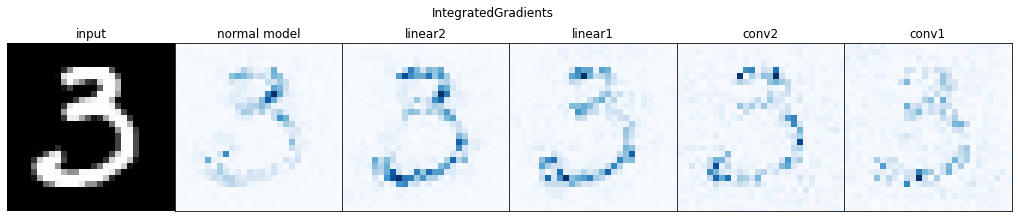

In [115]:
def visualize_cascading_randomization_single_example(model, module_paths, example, saliency_method):
    model_copy = copy.deepcopy(model)
    
    image, label = example
    
    # make plt plot
    ncols = len(module_paths) + 2
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(3*ncols, 3*1+0.5))
    fig.subplots_adjust(hspace=0, wspace=0)
    
    # show input image at the very left
    npimg = np.squeeze(np.squeeze(image.numpy()))
    axs[0].imshow(npimg, cmap='gray')
    axs[0].axis('off')
    
    # show visualizations before scrambling the model
    pred = model_copy(image).argmax(axis=1).item()
    sal_kwargs = get_kwargs(saliency_method, model_copy, image, label)
    fig, _ = visualize_saliency_method(sal_kwargs, image, (fig, axs[1]))

    # cascading randomization and visualization of IG
    # start with 1 because 0th column is unscrambled model
    for path, col in zip(module_paths, range(2, ncols)):
        util.rand_layers(model_copy, [path])
        pred = model_copy(image).argmax(axis=1).item()
        sal_kwargs = get_kwargs(saliency_method, model_copy, image, label)
        fig, _ = visualize_saliency_method(sal_kwargs, image, (fig, axs[col]))
    
    # set titles for each column
    col_titles = ['input', 'normal model'] + [x for x in map((lambda x: '_'.join(x)), module_paths)]
    for ax, col in zip(axs, col_titles):
        ax.set_title(col)
    
    # set title for the whole thing
    fig.suptitle(saliency_method.__name__)
    
    return fig, axs

for image, label in single_loader:
    fig, _ = visualize_cascading_randomization_single_example(model, module_paths, (image, label), IntegratedGradients)
    fig.show()
    break

In [116]:
def visualize_cascading_randomization2(model, module_paths, example, sal_methods, sal_method_names):
    model_copy = copy.deepcopy(model)
    image, label = example
    
    # make plt plot
    nrows = len(sal_methods)
    ncols = len(module_paths) + 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
    fig.subplots_adjust(hspace=0, wspace=0)
    
    # show input image at the very left
    for row in range(nrows):
        npimg = np.squeeze(np.squeeze(image.numpy()))
        axs[row, 0].imshow(npimg, cmap='gray')
        axs[row, 0].axis('on')
        axs[row, 0].set_xticks([])
        axs[row, 0].set_yticks([])
    
    # show visualizations before scrambling the model
    for sal_method, row in zip(sal_methods, range(nrows)):
        pred = model_copy(image).argmax(axis=1).item()
        sal_kwargs = get_kwargs(sal_method, model_copy, image, label)
        fig, _ = visualize_saliency_method(sal_kwargs, image, (fig, axs[row, 1]))

    # cascading randomization and visualization
    # start with 1 because 0th column is unscrambled model
    for path, col in zip(module_paths, range(2, ncols)):
        util.rand_layers(model_copy, [path])
        for sal_method, row in zip(sal_methods, range(nrows)):
            pred = model_copy(image).argmax(axis=1).item()
            sal_kwargs = get_kwargs(sal_method, model_copy, image, label)
            fig, _ = visualize_saliency_method(sal_kwargs, image, (fig, axs[row, col]))
    
    # set titles for each column
    col_titles = ['input', 'normal model'] + [x for x in map((lambda x: '_'.join(x)), module_paths)]
    for ax, col in zip(axs[0], col_titles):
        ax.set_title(col)
    
    # set titles for each row
    for ax, name in zip(axs[:,0], sal_method_names):
        ax.set_ylabel(name, rotation=90, size='large')
    
    # set title for the whole thing
    fig.suptitle("Cascading Randomization")
    
    return fig, axs

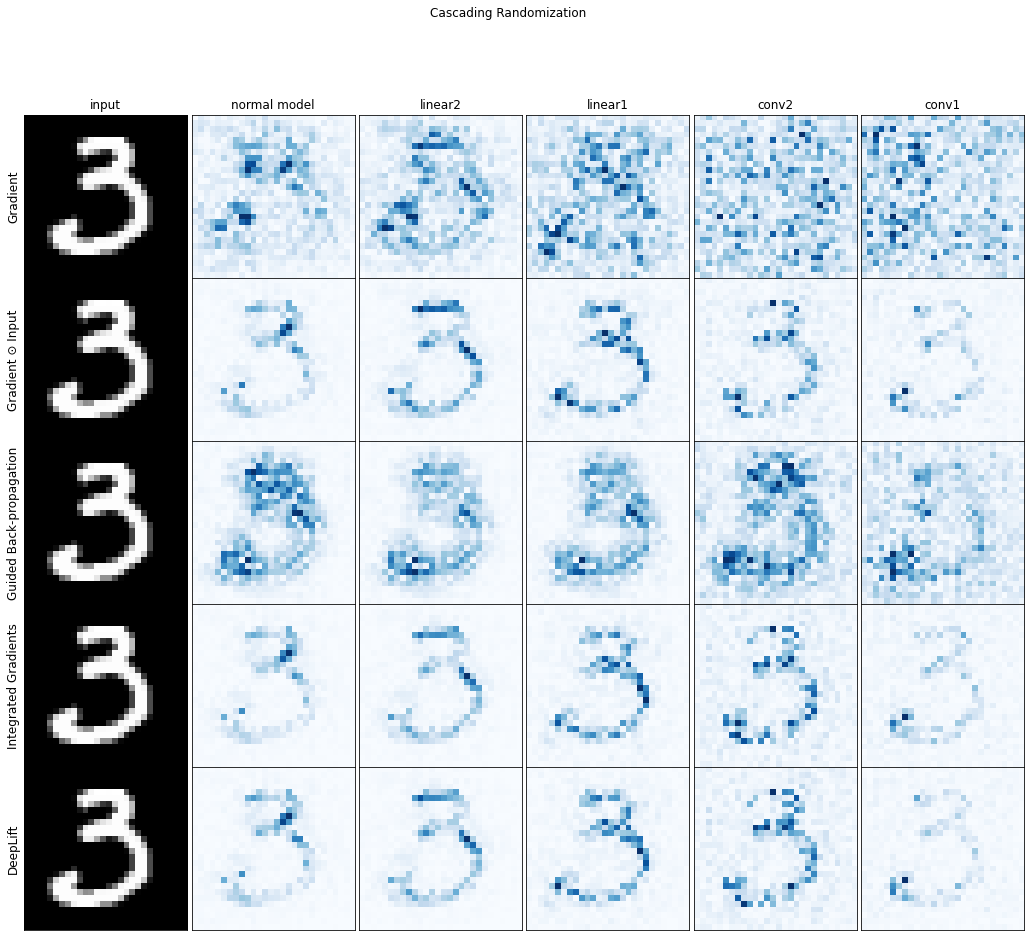

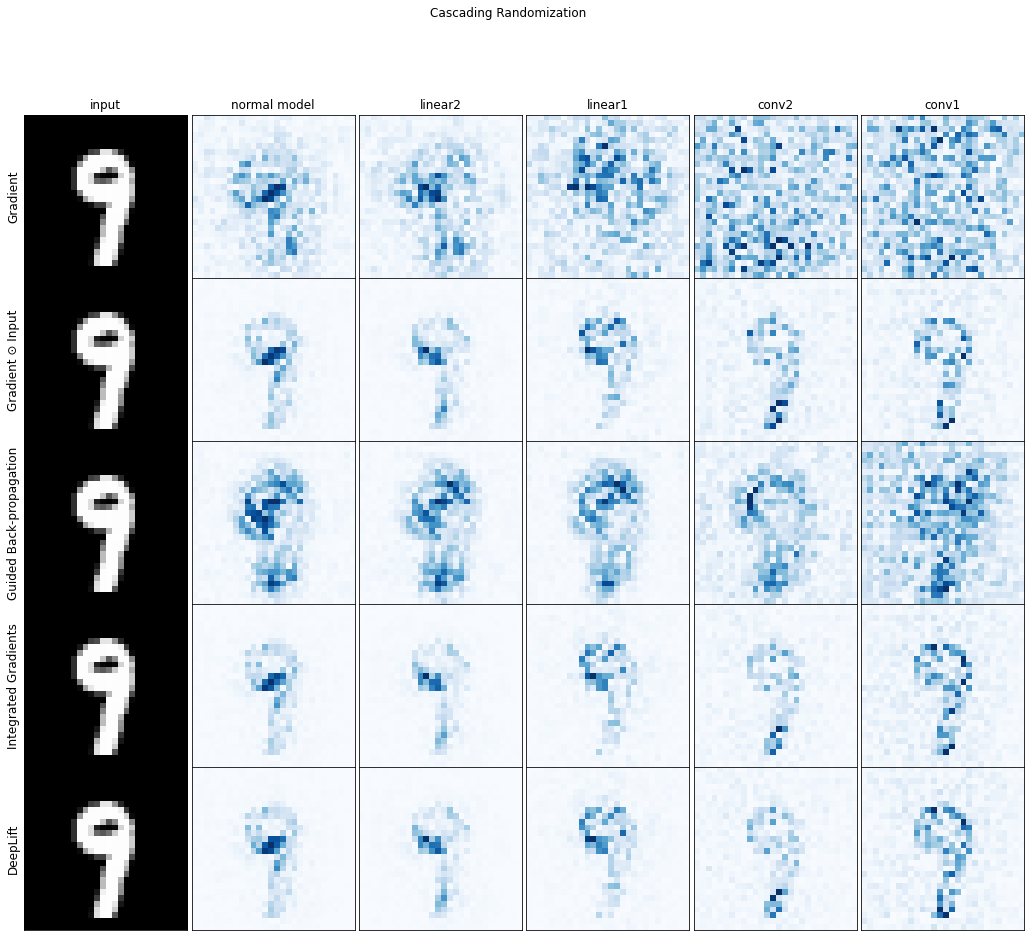

In [121]:
for image, label in single_loader:
    fig, _ = visualize_cascading_randomization2(
        model,
        module_paths,
        (image, label),
        [Saliency, InputXGradient, GuidedBackprop, IntegratedGradients, DeepLift],
        ['Gradient', 'Gradient ⊙ Input', 'Guided Back-propagation', 'Integrated Gradients', 'DeepLift']
    )
    fig.show()

In [ ]:
visualize_cascading_randomization(model, module_paths, single_loader, Saliency)

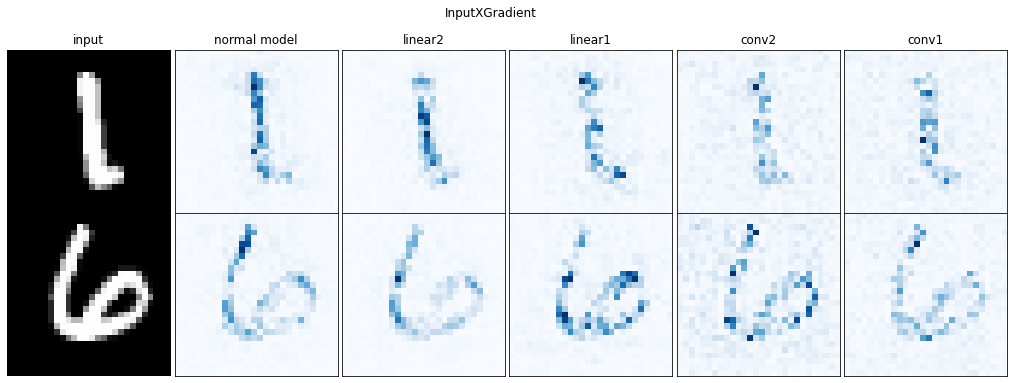

In [40]:
visualize_cascading_randomization(model, module_paths, single_loader, InputXGradient)

(<Figure size 1296x432 with 12 Axes>,
 array([[<AxesSubplot:title={'center':'input'}>,
         <AxesSubplot:title={'center':'normal model'}>,
         <AxesSubplot:title={'center':'linear2'}>,
         <AxesSubplot:title={'center':'linear1'}>,
         <AxesSubplot:title={'center':'conv2'}>,
         <AxesSubplot:title={'center':'conv1'}>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

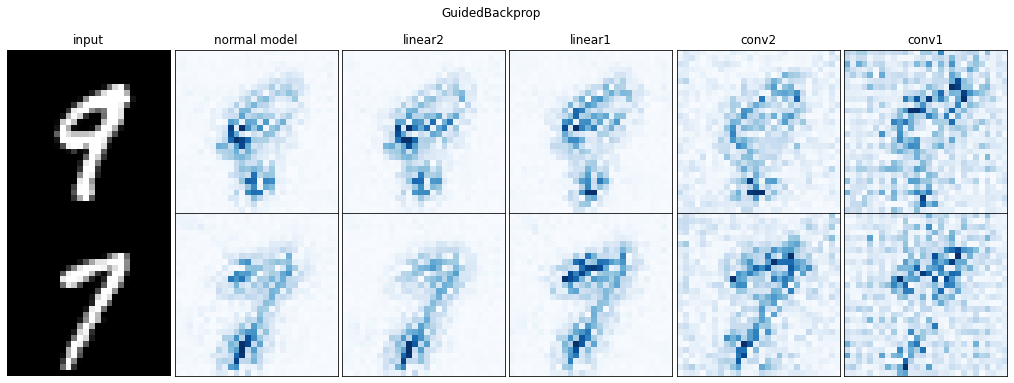

In [7]:
visualize_cascading_randomization(model, module_paths, single_loader, GuidedBackprop)